# Time Series Analysis on the max load each day

In [127]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

season_length = 365*24

In [128]:
def harmonic_approx(x, season_length, coef, intercept=0):
    sum = np.zeros(x.shape) + intercept

    for (i, (c, trig_fun)) in enumerate(zip(coef, itertools.cycle([np.sin, np.cos]))):
        d = i//2+1
        sum += c * trig_fun(x * d * 2*np.pi / season_length)
    
    return sum


def fit_tri(ydata, harmonic_degree, x=None, fit_intercept=False):

    if x is None:
        x = ydata.index #assuming that ydata is a Series

    harmonics = range(1, harmonic_degree+1)

    basis = []
    for multiplier in harmonics:
        basis.append(pd.Series( np.sin(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_sin'))
        basis.append(pd.Series( np.cos(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_cos'))

    trig_basis = pd.concat(basis, axis=1)

    lr = LinearRegression()
    model = lr.fit(trig_basis, ydata)
    if fit_intercept:
        intercept = model.intercept_
    else:
        intercept = 0
    
    approximation_result = harmonic_approx(x, season_length, model.coef_, intercept)

    return (model, approximation_result)

def plot_decomposition(seas_decomp_yearly, 
    labels=['Observed data (signal)','Trend (364 days moving average)', 'Seasonality', 'Residual'], file_name=''):
    
    # cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
    sns.set_palette(palette=cmaps_hex)
    sns_c = sns.color_palette(palette=cmaps_hex)

    # Plots:
    fig, ax = plt.subplots(3, 1, constrained_layout=True)

    #Plot Signal
    ax[0].set(title=labels[0], 
            ylabel='kWh')
    seas_decomp_yearly.observed.plot(color=sns_c[0], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[0])
    #Plot Trend
    ax[1].set(title=labels[1], 
            ylabel='kWh')
    seas_decomp_yearly.trend.plot(color=sns_c[1], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[1])
    #Plot Seasonality
    ax[2].set(title=labels[2], 
            ylabel='kWh')
    seas_decomp_yearly.seasonal.plot(
                                    color=sns_c[2], 
                                    linewidth=1,
                                    sharex=True,
                                    ax=ax[2])

    fig.savefig(file_name, dpi=450, bbox_inches='tight')




In [129]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)

COLOR_SUMMER = 'orange'#'#f9da21'
COLOR_WINTER = 'dodgerblue'#'#70b2b2'
COLOR_AUTUMN = '#9e9e9e'
COLOR_SPRING = '#97be6d'

cmaps_hex = [COLOR_WINTER, COLOR_SUMMER, COLOR_AUTUMN, COLOR_SPRING, COLOR_SUMMER, COLOR_WINTER]#'#70b2b2', '#f9da21', '#9e9e9e', '#97be6d', '#f9da21', '#70b2b2']

sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
date_form = DateFormatter("%m-%d")
sns.set(font_scale = 2)

In [130]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

In [131]:
data_df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    weekofyear = lambda x: x['timestamp'].dt.weekofyear,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)
weekly_data_df = data_df\
    .groupby(['date','year','month','weekofyear','day','dayofyear'], as_index=False)\
    .agg({'net_load_kWh':np.mean})\
    .set_index('date')

## Decomposition of the time series (yearly)

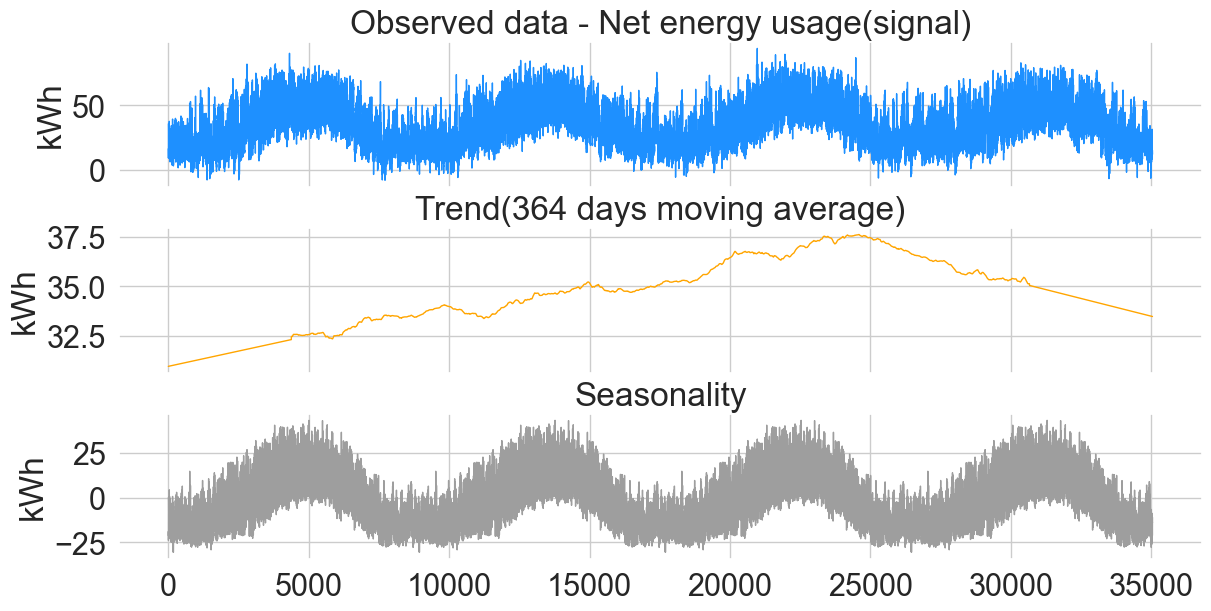

In [132]:
# Decomposition weekly (365 days)
decomp_yearly = seasonal_decompose(df['net_load_kWh'], model='add', 
    two_sided = True, period=365*24, extrapolate_trend=24*180)
# decomp_weekly.plot();
# plot_decomposition(decomp)
plot_decomposition(decomp_yearly, labels = ['Observed data - Net energy usage(signal)',
                    'Trend(364 days moving average)', 'Seasonality',
                    'Residual'],
                    file_name = '../images/decomposition_yearly_net_energy_usage.png')

## Yearly seasonality (Trigonometric calculation)

In [133]:
model,season = fit_tri(df['net_load_kWh'], 4)
# plt.plot(df['net_load_kWh'])
# plt.plot(season+model.intercept_)
df['season_Y'] = season

## Decomposition, Yearly, Weekly Hourly

In [134]:
df['trend_Y'] = decomp_yearly.trend
df.head()
df['decom_Y'] = df['net_load_kWh'] - df['season_Y'] - df['trend_Y']
df['date'] = df.datetime.dt.date
df['weekday'] = df.datetime.dt.weekday
df.groupby('date').mean()['decom_Y']
df['daily_rolling'] = df['decom_Y'].rolling(24, center=True, min_periods=1).mean()
daily_rolling = df.groupby('weekday').mean()['daily_rolling'].to_numpy()
df['season_W'] = df['weekday'].map(lambda x:daily_rolling[x]).rolling(24, center=True, min_periods=1).mean()
df['decom_W'] = df['decom_Y']-df['season_W']
df['hour'] = df.datetime.dt.hour
hourly_rolling = df.groupby('hour').mean()['decom_W'].to_numpy()
df['hourly_rolling'] = df['hour'].map(lambda x:hourly_rolling[x])
df['decom_H'] = df['decom_W'] - df['hourly_rolling']



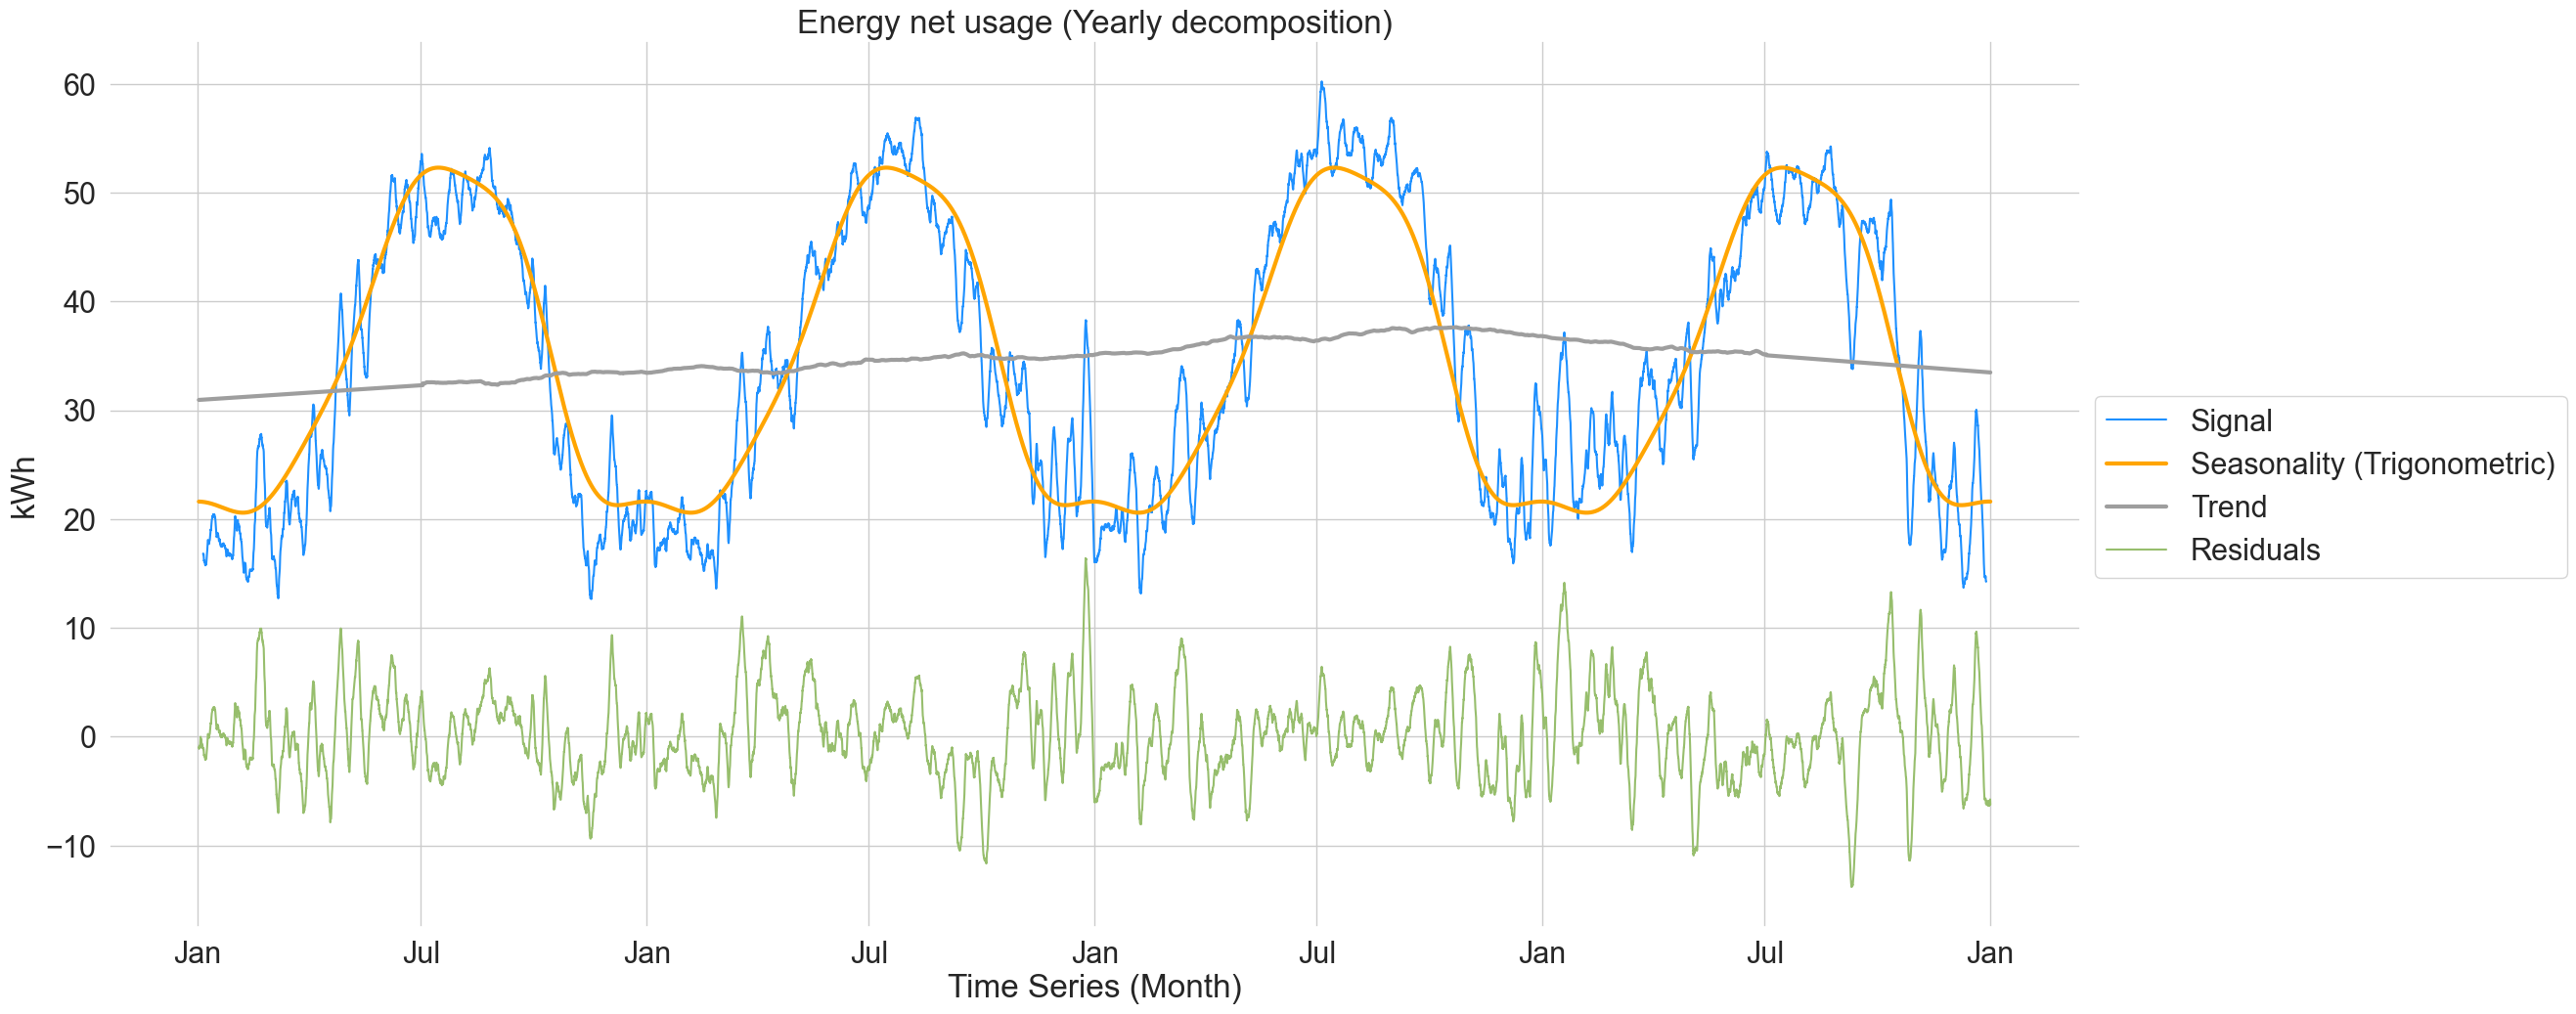

In [155]:
fig, ax = plt.subplots(figsize = (26,12))
ax = sns.lineplot(x = df['datetime'], y = df['net_load_kWh'].rolling(24*7, center=True).mean())
ax = sns.lineplot(x = df['datetime'], y = df['season_Y']+model.intercept_, linewidth =3)
ax = sns.lineplot(x = df['datetime'], y = df['trend_Y'], linewidth=3)
ax = sns.lineplot(x = df['datetime'], y = df['decom_Y'].rolling(24*7, center = True, min_periods=1).mean())
ax.set(title = 'Energy net usage (Yearly decomposition)', xlabel='Time Series (Month)', ylabel='kWh');
ax.xaxis.set_major_formatter(DateFormatter("%b"))
fig.legend(title='', loc='center left', bbox_to_anchor=(0.9, 0.5), labels=['Signal', 'Seasonality (Trigonometric)', 'Trend', 'Residuals'])
fig.savefig('../images/decomposition_yearly_net_energy_usage_trigonometric_seasonality.png', dpi=450, bbox_inches='tight')

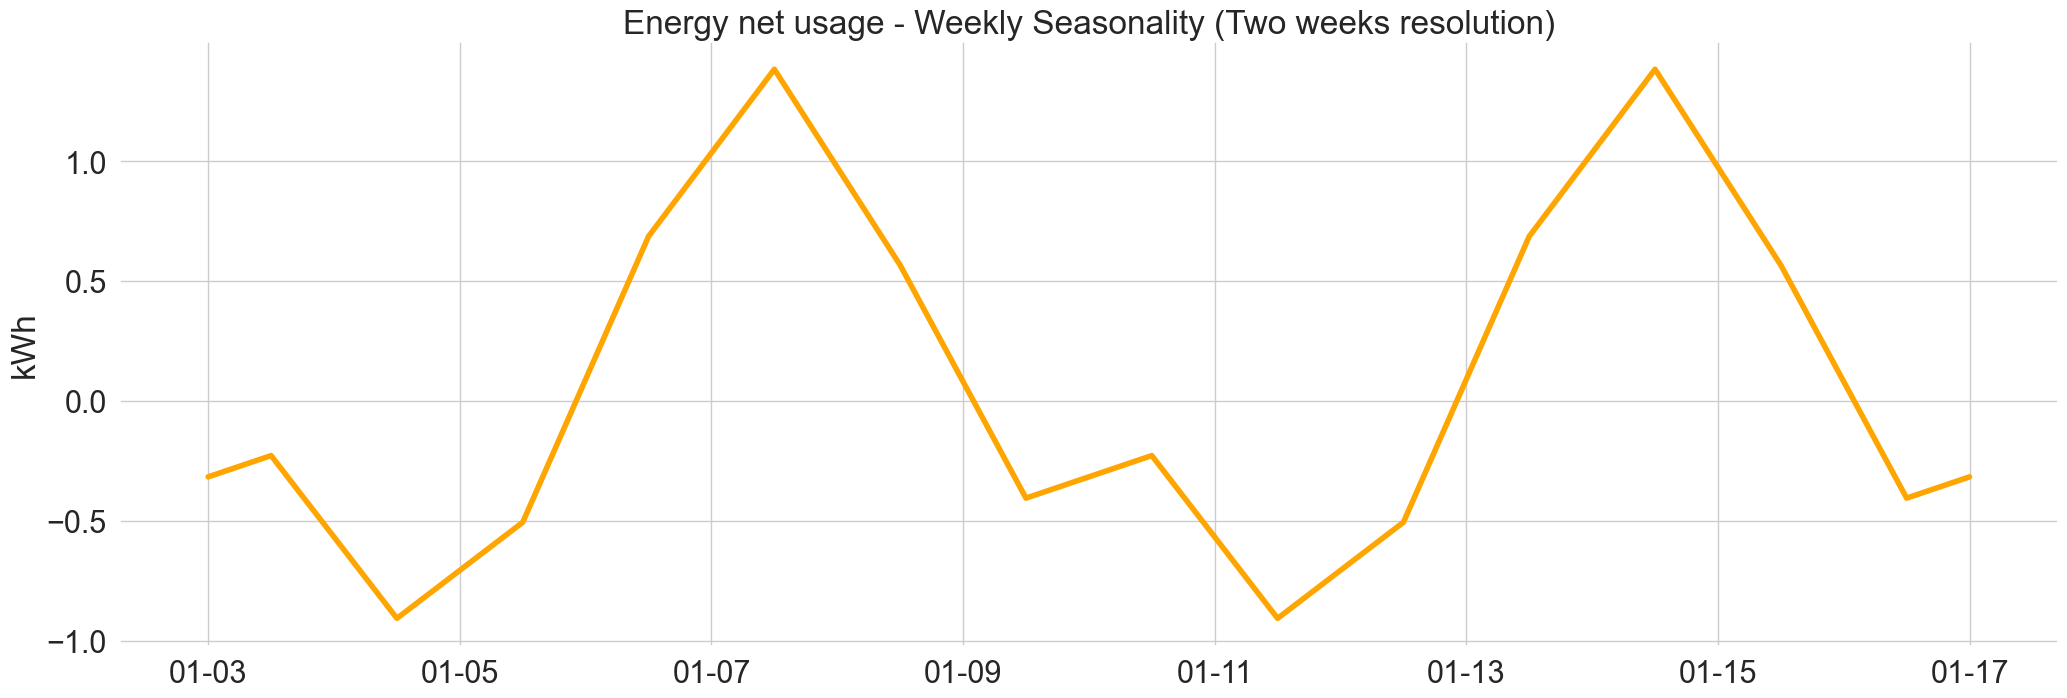

In [157]:
fig, ax = plt.subplots(figsize=(25,8))
ax = sns.lineplot(x = df['datetime'], y = df['season_W'][24:25+14*24], color = COLOR_SUMMER, linewidth=4)
ax.set(title='Energy net usage - Weekly Seasonality (Two weeks resolution)', xlabel='', ylabel='kWh')
ax.xaxis.set_major_formatter(date_form)
fig.savefig('../images/montly_seasonality_net_energy_usage_trigonometric.png', dpi=450, bbox_inches='tight');

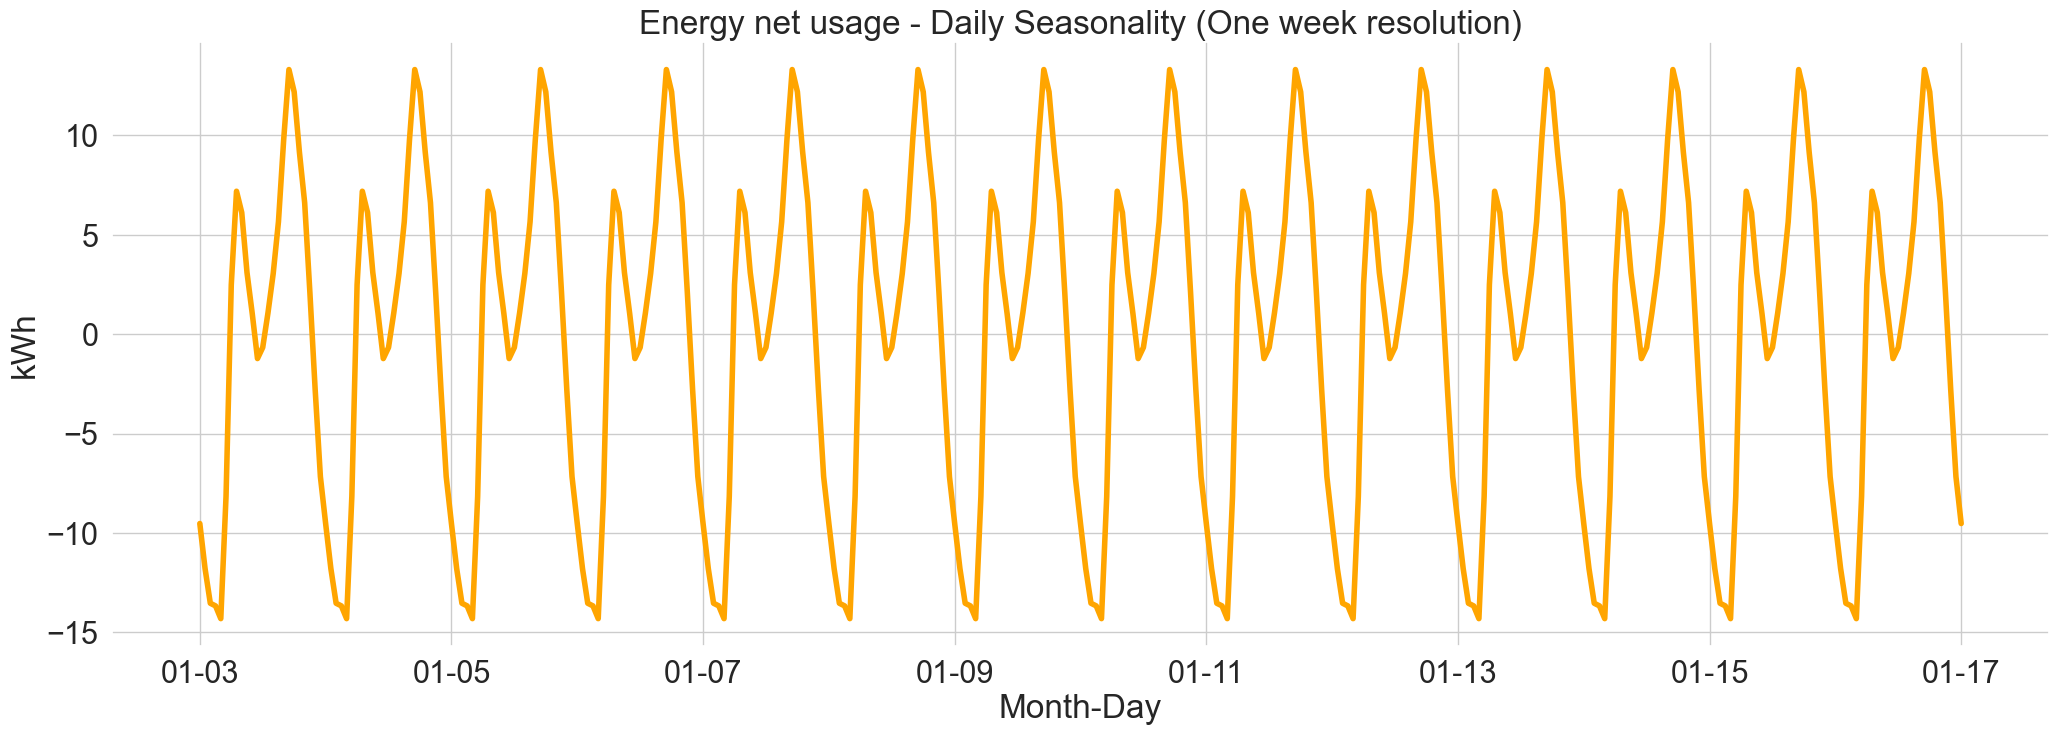

In [158]:
fig, ax = plt.subplots(figsize=(25,8))
ax = sns.lineplot(x = df['datetime'], y = df['hourly_rolling'][24:25+14*24], color = COLOR_SUMMER, linewidth=4)
ax.set(title='Energy net usage - Daily Seasonality (One week resolution)', xlabel='Month-Day', ylabel='kWh')
ax.xaxis.set_major_formatter(date_form)
fig.savefig('../images/daily_seasonality_net_energy_usage_trigonometric.png', dpi=450, bbox_inches='tight');

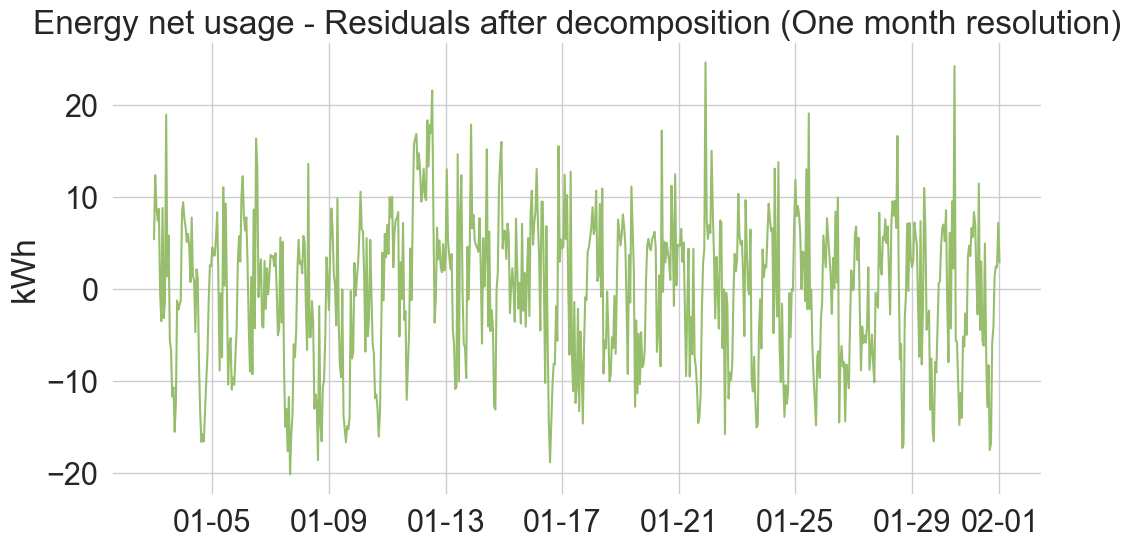

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(x = df['datetime'], y =df['decom_H'][24:25+24*29], color = COLOR_SPRING)
ax.set(title='Energy net usage - Residuals after decomposition (One month resolution)', xlabel='', ylabel='kWh')
ax.xaxis.set_major_formatter(date_form)
fig.savefig('../images/residuals_net_energy_usage.png', dpi=450, bbox_inches='tight');

In [ ]:
# df.groupby('weekday').mean()['daily_rolling'].plot()

In [ ]:
# df[0:24*14]['decom_W'].plot()

In [ ]:
# plt.plot(df['net_load_kWh'].rolling(24*7, center=True).mean())
# plt.plot(df['season_Y']+model.intercept_)

# plt.plot(df['trend_Y'])
# plt.plot(df['season_W'])
# plt.plot(df['decom_W'].rolling(24*7, center = True).mean())

In [ ]:
# plt.plot(df['net_load_kWh'].rolling(24*7, center=True).mean())
# plt.plot(df['season_Y']+model.intercept_)

# plt.plot(df['trend_Y'])
# plt.plot(df['season_W'])

# plt.plot(df['decom_W'].rolling(24*7, center = True).mean())

In [ ]:
# plt.boxplot(data=df, x='decom_H')

In [ ]:
# ma = [7, 30, 365]

# smooth_daily_data_df = weekly_data_df.reset_index()\
#     .assign(date = lambda x:x['date'].transform(pd.to_datetime))

# fig, ax = plt.subplots(len(ma)+1, 1,
#     constrained_layout=True, sharex=True)
# plt.suptitle('Net energy usage - Moving Average Smoothing', y=1.02)

# for i, m in enumerate(ma):
#     smooth_daily_data_df[f'net_load_ma{m}'] = smooth_daily_data_df['net_load_kWh']\
#         .rolling(window=m, center=True).mean()

#     sns.lineplot(x='date', y ='net_load_kWh', label = 'Net energy usage (Signal)', 
#         data = smooth_daily_data_df, ax=ax[i])
#     sns.lineplot(x='date', y =f'net_load_ma{m}',
#         label=f'Net energy usage smoothed:\n ma={m} days',
#         data = smooth_daily_data_df, color = COLOR_SUMMER, ax=ax[i])
#     ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
#     ax[i].set(title='', ylabel='kWh');
# sns.lineplot(x='date', y =f'net_load_ma{m}',
#     label=f'Net load smoothed:\n ma={m} days',
#     data = smooth_daily_data_df, color=sns_c[1], ax=ax[i+1])
# ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
# ax[i+1].set(title='', xlabel='', ylabel='kWh');
# fig.savefig('../images/moving_average_smoothing_net_energy_usage.png', dpi=450, bbox_inches='tight')